In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("processed_dataset.csv")
df = df.sample(frac=1).reset_index(drop=True)

text = df['text']

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

maxlen = 400
max_words = 25000

text_tokenizer = Tokenizer(num_words = max_words)
text_tokenizer.fit_on_texts(text)
text_sequences = pad_sequences(text_tokenizer.texts_to_sequences(text), maxlen = maxlen, padding='pre')
y = np.array(df.iloc[:,2:])
word_index = text_tokenizer.word_index

X_train, X_test, y_train, y_test = train_test_split(text_sequences, y, test_size= 0.15)

In [4]:
embedding_dict = {}

with open("../glove/archive/glove.6B.100d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],"float32")
        embedding_dict[word] = vectors
f.close()

embedding_dim = 100
num_words = max_words + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            weights = [embedding_matrix],
                            input_length=maxlen,
                            trainable= False)

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units = 128, return_sequences = True))
model.add(LSTM(units = 32))
model.add(Dense(units = 16, activation = "relu"))
model.add(Dense(units = 5, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2500100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 400, 128)          117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 2,638,569
Trainable params: 138,469
Non-trainable params: 2,500,100
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, batch_size=16, epochs = 20, validation_data= (X_test, y_test), verbose = 1)

Epoch 1/20
119/119 [==============================] - 26s 215ms/step - loss: 1.3293 - accuracy: 0.4405 - val_loss: 1.0461 - val_accuracy: 0.5868
Epoch 2/20
119/119 [==============================] - 24s 205ms/step - loss: 1.3474 - accuracy: 0.4178 - val_loss: 1.3149 - val_accuracy: 0.4611
Epoch 3/20
119/119 [==============================] - 24s 204ms/step - loss: 1.0871 - accuracy: 0.5299 - val_loss: 0.8283 - val_accuracy: 0.6048
Epoch 4/20
119/119 [==============================] - 24s 204ms/step - loss: 0.8416 - accuracy: 0.6118 - val_loss: 0.7771 - val_accuracy: 0.6617
Epoch 5/20
119/119 [==============================] - 25s 207ms/step - loss: 0.7999 - accuracy: 0.6748 - val_loss: 0.5505 - val_accuracy: 0.7335
Epoch 6/20
119/119 [==============================] - 25s 210ms/step - loss: 0.5837 - accuracy: 0.8091 - val_loss: 0.4352 - val_accuracy: 0.8623
Epoch 7/20
119/119 [==============================] - 357s 3s/step - loss: 0.3899 - accuracy: 0.8689 - val_loss: 0.2542 - val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


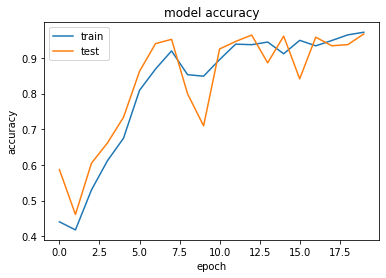

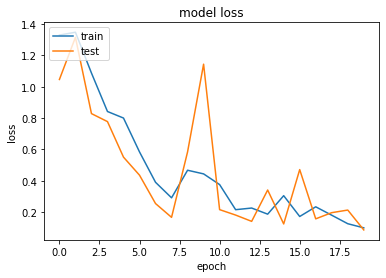

In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()